In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import time
from datetime import datetime
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

from part1.dataset import PalindromeDataset
from part1.vanilla_rnn import VanillaRNN
from part1.lstm import LSTM


In [2]:
class VanillaRNN(nn.Module):

    def __init__(
        self, seq_length, input_dim, num_hidden, num_classes, batch_size, device="cpu"
    ):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.device = device

        self.Whx = torch.nn.Parameter(torch.randn(self.seq_length, self.num_hidden))
        self.Whh = torch.nn.Parameter(torch.randn(self.num_hidden, self.num_hidden))
        self.Why = torch.nn.Parameter(torch.randn(self.num_hidden, self.num_classes))
        self.bh = torch.nn.Parameter(torch.zeros(self.num_hidden))
        self.by = torch.nn.Parameter(torch.zeros(self.num_classes))

        # When I dont register the parameters, the parameters are not visible, the model is not trainable
        self.register_parameter('Whx_param', self.Whx)
        self.register_parameter('Whh_param', self.Whh)
        self.register_parameter('Why_param', self.Why)
        self.register_parameter('bh_param', self.bh)
        self.register_parameter('by_param', self.by)

    def forward(self, input, h_prev):
        h_next = torch.tanh(input @ self.Whx + h_prev @ self.Whh + self.bh)
        y = h_next @ self.Why + self.by
        return y, h_next


In [3]:
def train(config):
    device = torch.device(config.device)

    model = VanillaRNN(seq_length=config.input_length, input_dim=config.input_dim, num_hidden=config.num_hidden,
                       num_classes=config.num_classes, batch_size=config.batch_size, device=device)
    
    model = model.to(device)  
    dataset = PalindromeDataset(config.input_length + 1)
    data_loader = DataLoader(dataset, config.batch_size, num_workers=1)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

    for step, (batch_inputs, batch_targets) in enumerate(data_loader):
        model.train()
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        optimizer.zero_grad()

        h_prev = torch.zeros(config.batch_size, config.num_hidden).to(device)

        outputs, _ = model(batch_inputs, h_prev)
        outputs = nn.functional.log_softmax(outputs, dim=1)
        loss = criterion(outputs, batch_targets.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.max_norm)  

        optimizer.step()
        loss = loss.item()
        accuracy = (outputs.argmax(dim=1) == batch_targets.view(-1)).float().mean()

        if step % 1000 == 0:
            print(
                "[{}] Train Step {:04d}/{:04d}, Batch Size = {}, "
                "Accuracy = {:.2f}, Loss = {:.3f}".format(
                    datetime.now().strftime("%Y-%m-%d %H:%M"),
                    step,
                    config.train_steps,
                    config.batch_size,
                    accuracy,
                    loss,
                )
            )

        if step == config.train_steps:
            break

    print("Done training.")
    return accuracy

In [4]:
import matplotlib.pyplot as plt
accuracies = []
for i in range(5, 55, 5):
    config = {
        "model_type": "RNN",           
        "input_length": i,            
        "input_dim": 1,                
        "num_classes": 10,             
        "num_hidden": 128,             
        "batch_size": 128,             
        "learning_rate": 0.001,        
        "train_steps": 10000,          
        "max_norm": 10.0,              
        "device": "cuda:0"             
    }

    accuracy = train(argparse.Namespace(**config))
    accuracies.append(accuracy)

c:\Users\kutay\miniconda3\envs\deepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-06-23 14:56] Train Step 0000/10000, Batch Size = 128, Accuracy = 0.17, Loss = 16.586
[2024-06-23 14:56] Train Step 1000/10000, Batch Size = 128, Accuracy = 0.59, Loss = 0.889
[2024-06-23 14:56] Train Step 2000/10000, Batch Size = 128, Accuracy = 0.77, Loss = 0.578
[2024-06-23 14:56] Train Step 3000/10000, Batch Size = 128, Accuracy = 0.88, Loss = 0.403
[2024-06-23 14:56] Train Step 4000/10000, Batch Size = 128, Accuracy = 0.97, Loss = 0.282
[2024-06-23 14:56] Train Step 5000/10000, Batch Size = 128, Accuracy = 0.99, Loss = 0.167
[2024-06-23 14:56] Train Step 6000/10000, Batch Size = 128, Accuracy = 0.98, Loss = 0.116
[2024-06-23 14:56] Train Step 7000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.049
[2024-06-23 14:56] Train Step 8000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.022
[2024-06-23 14:56] Train Step 9000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.011
[2024-06-23 14:57] Train Step 10000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.005
Done tra

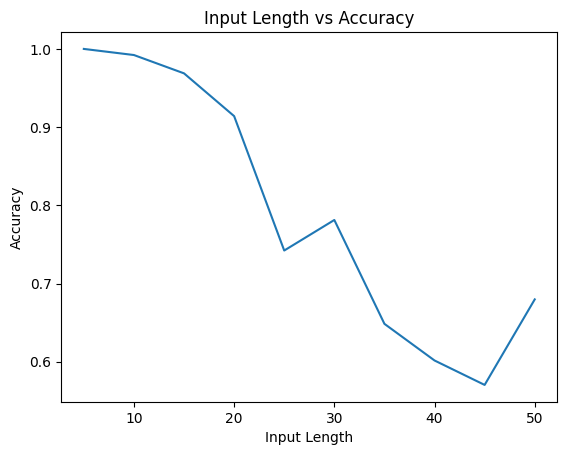

In [6]:
accuracies_list = []
for accuracy in accuracies:
    accuracies_list.append(accuracy.item())

plt.plot(range(5, 55, 5), accuracies_list)
plt.xlabel('Input Length')
plt.ylabel('Accuracy')
plt.title('Input Length vs Accuracy')

plt.show()

### Momentum

Momentum updates accelerate gradient descent by adding an exponentially decaying average of past gradients. This helps the optimizer to move more quickly in the relevant directions and navigate through flatter regions of the loss landscape.

### RMSProp

RMSProp adjusts the learning rates based on the root mean square of the gradients, which helps in handling varying scales of gradients effectively. By scaling the learning rates inversely proportional to the gradients' RMS, RMSProp can converge faster and more reliably.

### Adam

Adam integrates the benefits of both momentum and RMSProp. It adapts the learning rates for each parameter based on the first moment (mean) and second moment (uncentered variance) of the gradients. This adaptive learning rate mechanism allows Adam to handle varying gradients effectively, while momentum helps in maintaining a steady pace through regions with small but consistent gradients. 

In [7]:
class LSTM(nn.Module):

    def __init__(
        self, seq_length, input_dim, num_hidden, num_classes, batch_size, device="cpu"
    ):
        super(LSTM, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.device = device

        self.W_gx = nn.Parameter(torch.randn(self.input_dim, self.num_hidden))
        self.W_gh = nn.Parameter(torch.randn(self.num_hidden, self.num_hidden))
        self.b_g = nn.Parameter(torch.zeros(self.num_hidden))

        self.W_ix = nn.Parameter(torch.randn(self.input_dim, self.num_hidden))
        self.W_ih = nn.Parameter(torch.randn(self.num_hidden, self.num_hidden))
        self.b_i = nn.Parameter(torch.zeros(self.num_hidden))

        self.W_fx = nn.Parameter(torch.randn(self.input_dim, self.num_hidden))
        self.W_fh = nn.Parameter(torch.randn(self.num_hidden, self.num_hidden))
        self.b_f = nn.Parameter(torch.zeros(self.num_hidden))

        self.W_ox = nn.Parameter(torch.randn(self.input_dim, self.num_hidden))
        self.W_oh = nn.Parameter(torch.randn(self.num_hidden, self.num_hidden))
        self.b_o = nn.Parameter(torch.zeros(self.num_hidden))

        self.W_ph = nn.Parameter(torch.randn(self.num_hidden, self.num_classes))
        self.b_p = nn.Parameter(torch.zeros(self.num_classes))

        self.c = torch.zeros(self.batch_size, self.num_hidden).to(self.device)
        self.h = torch.zeros(self.batch_size, self.num_hidden).to(self.device)

    def forward(self, x):
        g = torch.tanh(x @ self.W_gx + self.h @ self.W_gh + self.b_g)
        i = torch.sigmoid(x @ self.W_ix + self.h @ self.W_ih + self.b_i)
        f = torch.sigmoid(x @ self.W_fx + self.h @ self.W_fh + self.b_f)
        o = torch.sigmoid(x @ self.W_ox + self.h @ self.W_oh + self.b_o)

        self.c = torch.mul(i, g) + torch.mul(f, self.c)
        self.h = torch.mul(o, torch.tanh(self.c))

        p = self.h @ self.W_ph + self.b_p

        return p, self.h


In [8]:
accuracies = []
for i in range(5, 55, 5):
    config = {
        "model_type": "LSTM",           
        "input_length": i,            
        "input_dim": 1,                
        "num_classes": 10,             
        "num_hidden": 128,             
        "batch_size": 128,             
        "learning_rate": 0.001,        
        "train_steps": 10000,          
        "max_norm": 10.0,              
        "device": "cuda:0"             
    }

    accuracy = train(argparse.Namespace(**config))
    accuracies.append(accuracy)

[2024-06-23 15:25] Train Step 0000/10000, Batch Size = 128, Accuracy = 0.12, Loss = 13.016
[2024-06-23 15:25] Train Step 1000/10000, Batch Size = 128, Accuracy = 0.51, Loss = 1.139
[2024-06-23 15:25] Train Step 2000/10000, Batch Size = 128, Accuracy = 0.74, Loss = 0.768
[2024-06-23 15:25] Train Step 3000/10000, Batch Size = 128, Accuracy = 0.88, Loss = 0.469
[2024-06-23 15:25] Train Step 4000/10000, Batch Size = 128, Accuracy = 0.93, Loss = 0.330
[2024-06-23 15:26] Train Step 5000/10000, Batch Size = 128, Accuracy = 0.99, Loss = 0.189
[2024-06-23 15:26] Train Step 6000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.110
[2024-06-23 15:26] Train Step 7000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.073
[2024-06-23 15:26] Train Step 8000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.030
[2024-06-23 15:26] Train Step 9000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.011
[2024-06-23 15:26] Train Step 10000/10000, Batch Size = 128, Accuracy = 1.00, Loss = 0.004
Done tra

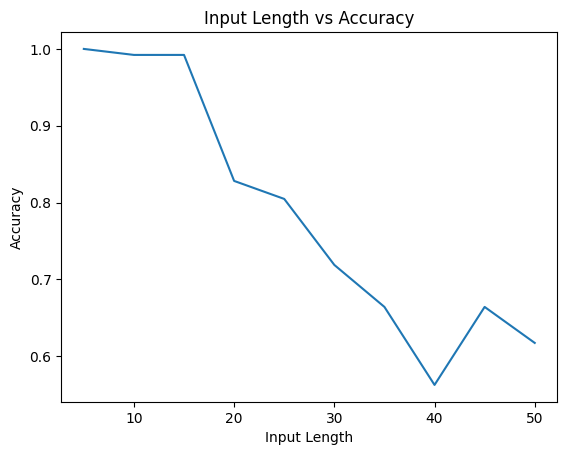

In [9]:
accuracies_list = []
for accuracy in accuracies:
    accuracies_list.append(accuracy.item())

plt.plot(range(5, 55, 5), accuracies_list)
plt.xlabel('Input Length')
plt.ylabel('Accuracy')
plt.title('Input Length vs Accuracy')

plt.show()

![Image](solutions/1.jpg)

![Image](solutions/2.jpg)

![Image](solutions/3.jpg)

![Image](solutions/4.jpg)